Dans ce notebook, vous apprendrez à classer des images de chats et de chiens en utilisant un transfert learning à partir d'un réseau pré-entraîné sur le jeu de données [ImageNet](https://www.image-net.org/update-mar-11-2021.php).

# Importation des données

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chargement des données

Téléchargement des données

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Sauvegarde des PATH

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Fixer les hyperparamètres

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Initialiser les générateurs

Pour le jeu d'entraînement.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   vertical_flip=True)

train_gen = train_datagen.flow_from_directory(
directory=train_dir,
target_size=IMG_SIZE,
batch_size=BATCH_SIZE,
class_mode='binary',
shuffle=True)

Found 2000 images belonging to 2 classes.


Pour le jeu de validation.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = validation_datagen.flow_from_directory(
directory=validation_dir,
target_size=IMG_SIZE,
batch_size=BATCH_SIZE,
class_mode='binary',
shuffle=True)

Found 1000 images belonging to 2 classes.


#  Charger un modèle pré-entraîné

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Regarder la dimension de ce que le modèle nous retourne à partir de nos images en (160, 160, 3).

In [ ]:
feature_batch = base_model.predict(train_gen, steps=1)
print(feature_batch.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(32, 5, 5, 1280)


Fixer le modèle de base pour que les poids ne soient pas mis-à-jour.

In [ ]:
base_model.trainable = False

Viualiser l'architecture du modèle pré-entraîné.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Moyenner la dernière couche de convolution en un vecteur grâce à la fonction `GlobalAveragePooling2D`.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Ajoute une couche `Dense` au modèle.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Initialiser le nouveau modèle en prenant en compte les deux couches précédentes.

In [ ]:
# layers initialization
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model initialization
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compiler le modèle

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Visualiser le modèle

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Regarder le nombre de couches entrainables.

In [ ]:
len(model.trainable_variables)

2

# Entraînement du modèle

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_gen)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 649ms/step - accuracy: 0.2302 - loss: 1.1282


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.14
initial accuracy: 0.23


In [ ]:
history = model.fit(train_gen,
                    epochs=initial_epochs,
                    validation_data=validation_gen)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3403 - loss: 1.0694 - val_accuracy: 0.4630 - val_loss: 0.8182
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4864 - loss: 0.8209 - val_accuracy: 0.6610 - val_loss: 0.6111
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6295 - loss: 0.6675 - val_accuracy: 0.8060 - val_loss: 0.4748
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7369 - loss: 0.5347 - val_accuracy: 0.8640 - val_loss: 0.3888
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7835 - loss: 0.4839 - val_accuracy: 0.8950 - val_loss: 0.3289
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8037 - loss: 0.4416 - val_accuracy: 0.9090 - val_loss: 0.2884
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8160 - loss: 0.4152 - val_accuracy: 0.9170 - val_loss: 0.2595
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8341 - loss: 0.3945 - val_accuracy: 0.9200 - val_loss:

# Les courbes d'apprentissage

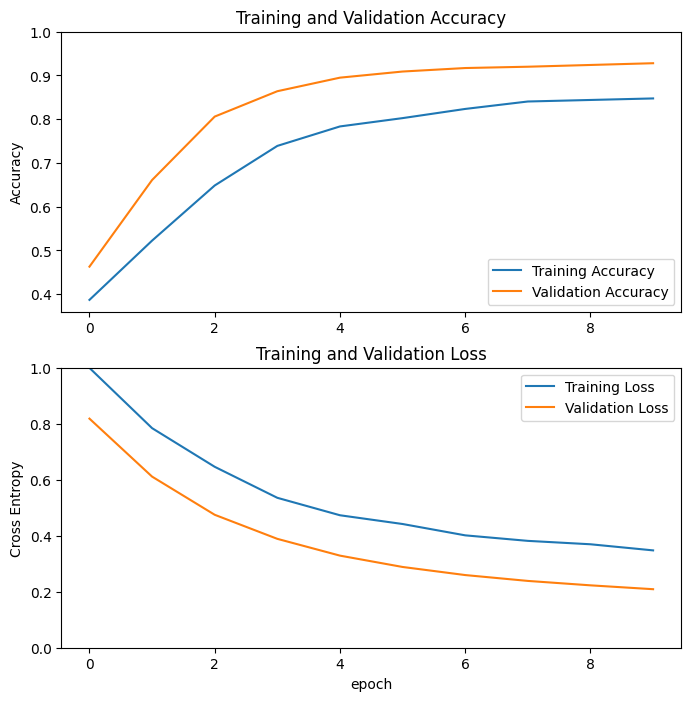

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compiler le nouveau modèle

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Visualiser le nouveau modèle

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

Regarder combien de couches sont entrainables.

In [ ]:
len(model.trainable_variables)

56

Continuer l'entraînement du modèle avec toutes les couches entrainables.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_gen,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_gen)

Epoch 10/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7126 - loss: 0.5408 - val_accuracy: 0.9570 - val_loss: 0.1561
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8134 - loss: 0.3927 - val_accuracy: 0.9610 - val_loss: 0.1354
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8710 - loss: 0.3015 - val_accuracy: 0.9640 - val_loss: 0.1224
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8887 - loss: 0.2780 - val_accuracy: 0.9640 - val_loss: 0.1151
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9049 - loss: 0.2487 - val_accuracy: 0.9670 - val_loss: 0.1074
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9223 - loss: 0.1979 - val_accuracy: 0.9670 - val_loss: 0.1033
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9173 - loss: 0.2065 - val_accuracy: 0.9660 - val_loss: 0.1001
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9312 - loss: 0.1891 - val_accuracy: 0.9660 - val_los

Agglomération des vecteurs de résultats.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Visualiser les performances

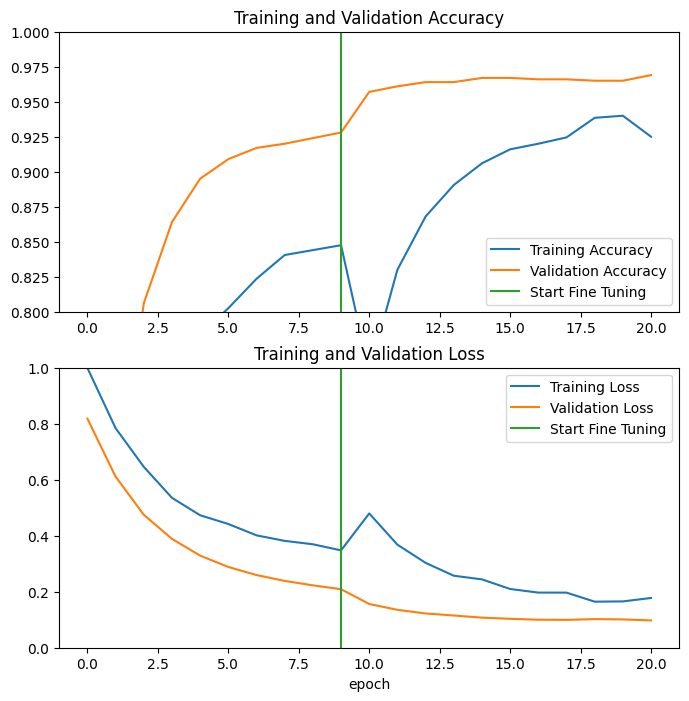

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()